# Classifier model exploration

In [1]:
import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

## Access processed data

In [2]:
DIR_REPO = Path.cwd().parent.parent
DIR_MINIO = DIR_REPO.parent.parent / "shared-storage" / "ny-price-estimator"
DIR_DATA = DIR_MINIO / "data"
DIR_DATA_RAW = Path(DIR_DATA) / "base"
DIR_DATA_PROCESSED = Path(DIR_DATA) / "created"

os.listdir(DIR_DATA_PROCESSED)

['listings_processed.csv']

In [3]:
FILEPATH_PROCESSED = DIR_DATA_PROCESSED / "listings_processed.csv"

In [4]:
df = pd.read_csv(FILEPATH_PROCESSED, index_col=0)
df.head()

,id,neighbourhood,property_type,room_type,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,...,price,category,TV,Internet,Air_conditioning,Kitchen,Heating,Wifi,Elevator,Breakfast
0,15509,Brooklyn,Apartment,Private room,11221,40.685384,-73.932709,2,NaN,1.0,...,59,0.0,1,0,0,1,1,1,0,0
1,2515,Manhattan,Apartment,Private room,10026,40.799205,-73.953676,3,1.0,1.0,...,59,0.0,1,1,1,1,1,1,0,0
2,2539,Brooklyn,Apartment,Private room,11218,40.647486,-73.972370,4,1.0,1.0,...,149,1.0,1,1,0,1,1,1,1,0
3,2595,Manhattan,Apartment,Entire home/apt,10018,40.753621,-73.983774,2,1.0,0.0,...,225,2.0,1,0,1,1,1,1,0,0
4,15729,Brooklyn,House,Private room,11231,40.676947,-74.011209,4,1.0,1.0,...,89,0.0,0,0,1,1,1,1,0,0


## Further processing of categorical variables

In [5]:
df = df.dropna(axis=0)

In [6]:
room2cat = {'Shared room': 1,
              'Private room': 2,
              'Entire home/apt': 3,
              'Hotel room': 4}
cat2room = {value: key for key, value in room2cat.items()}

df['room_type'] = df['room_type'].map(room2cat)

In [7]:
neigh2cat = {'Bronx': 1,
              'Queens': 2,
              'Staten Island': 3,
              'Brooklyn': 4,
              'Manhattan': 5}
cat2neigh = {value: key for key, value in neigh2cat.items()}

df['neighbourhood'] = df['neighbourhood'].map(neigh2cat)

In [8]:
df.head()

,id,neighbourhood,property_type,room_type,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,...,price,category,TV,Internet,Air_conditioning,Kitchen,Heating,Wifi,Elevator,Breakfast
1,2515,5,Apartment,2,10026,40.799205,-73.953676,3,1.0,1.0,...,59,0.0,1,1,1,1,1,1,0,0
2,2539,4,Apartment,2,11218,40.647486,-73.972370,4,1.0,1.0,...,149,1.0,1,1,0,1,1,1,1,0
3,2595,5,Apartment,3,10018,40.753621,-73.983774,2,1.0,0.0,...,225,2.0,1,0,1,1,1,1,0,0
4,15729,4,House,2,11231,40.676947,-74.011209,4,1.0,1.0,...,89,0.0,0,0,1,1,1,1,0,0
5,3330,4,Apartment,2,11206,40.708558,-73.942362,2,1.0,1.0,...,70,0.0,1,1,0,1,1,1,1,0


In [9]:
df.columns

Index(['id', 'neighbourhood', 'property_type', 'room_type', 'zipcode',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'category', 'TV', 'Internet',
       'Air_conditioning', 'Kitchen', 'Heating', 'Wifi', 'Elevator',
       'Breakfast'],
      dtype='object')

In [10]:
FEATURE_NAMES = ['neighbourhood', 'room_type', 'accommodates', 'bathrooms', 'bedrooms']

X = df[FEATURE_NAMES]
y = df['category']

## Split data for cross-validation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

## A simple classifier model

### Train the model

In [12]:
clf = RandomForestClassifier(n_estimators=120, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=120, random_state=0)

### Evaluate the model

In [13]:
y_pred = clf.predict(X_test)

In [14]:
accuracy_score(y_test, y_pred)

0.6708266237251744

Text(0.5, 0, 'Feature importance')

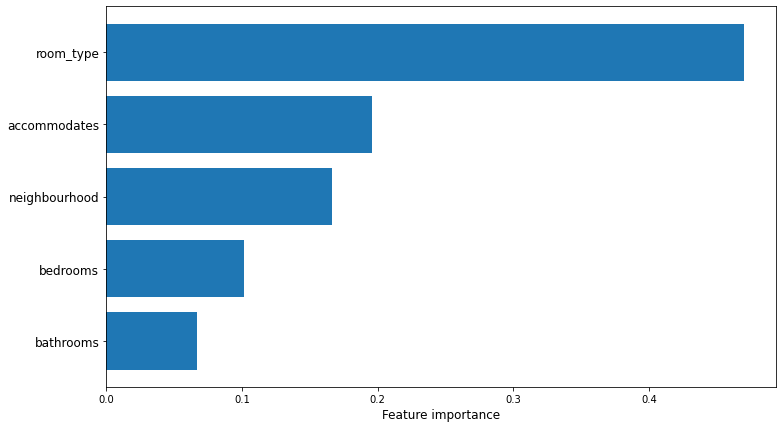

In [15]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns[indices]
importances = importances[indices]

fig, ax = plt.subplots(figsize=(12, 7))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), features, fontsize=12)
ax.invert_yaxis()
ax.set_xlabel("Feature importance", fontsize=12)

Text(0.5, 1.0, 'Simple model')

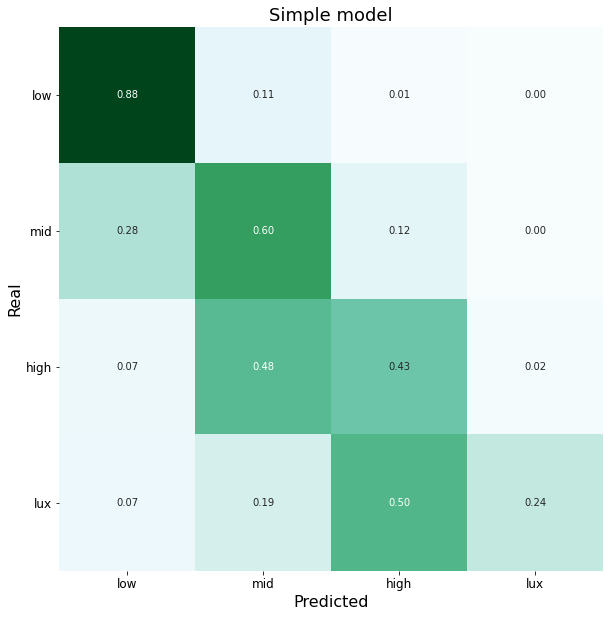

In [16]:
classes = [0, 1, 2, 3]
labels = ['low', 'mid', 'high', 'lux']

c = confusion_matrix(y_test, y_pred)
c = c / c.sum(axis=1).reshape(len(classes), 1)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(c, annot=True, cmap='BuGn', square=True, fmt='.2f', annot_kws={'size': 10}, cbar=False)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Real', fontsize=16)
plt.xticks(ticks=np.arange(.5, len(classes)), labels=labels, rotation=0, fontsize=12)
plt.yticks(ticks=np.arange(.5, len(classes)), labels=labels, rotation=0, fontsize=12)

plt.title("Simple model", fontsize=18)
plt.show()

In [32]:
maps = {'0.0': 'low', '1.0': 'mid', '2.0': 'high', '3.0': 'lux'}

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame.from_dict(report).T[:-3]
df_report.index = [maps[i] for i in df_report.index]
df_report

,precision,recall,f1-score,support
0.0,0.755996,0.880195,0.813381,3080.0
1.0,0.596076,0.599628,0.597846,2685.0
2.0,0.582788,0.426420,0.492490,1461.0
3.0,0.572917,0.243363,0.341615,226.0


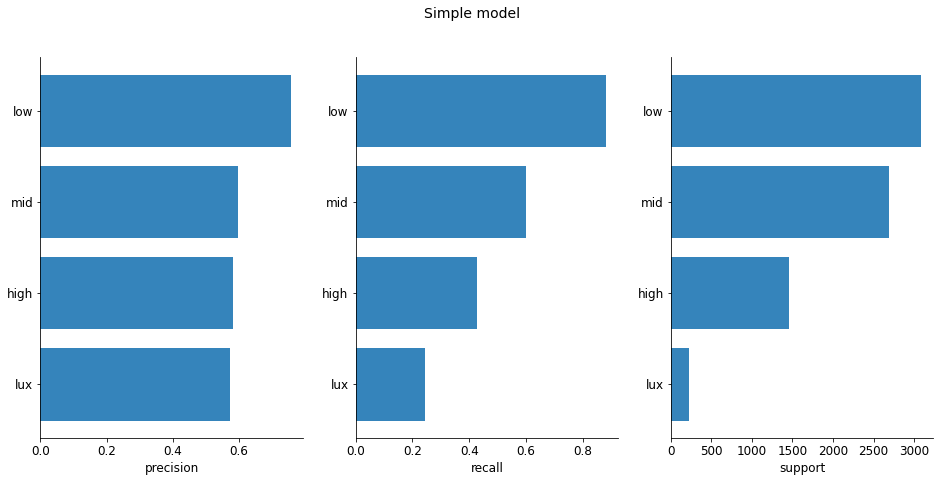

In [21]:
metrics = ['precision', 'recall', 'support']

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 7))

for i, ax in enumerate(axes):

    ax.barh(df_report.index, df_report[metrics[i]], alpha=0.9)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(metrics[i], fontsize=12)
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle("Simple model", fontsize=14)
plt.show()